Recreate the data we used in the previous codealong

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

column_names = ['id',
                'clump_thickness',
                'cell_size_uniformity',
                'cell_shape_uniformity',
                'marginal_adhesion',
                'single_epithelial_size',
                'bare_nuclei',
                'bland_chromatin',
                'normal_nucleoli',
                'mitoses',
                'class']

bcw = pd.read_csv('../assets/datasets/breast-cancer-wisconsin.csv',
                 names=column_names, na_values=['?'])

bcw.dropna(inplace=True)
bcw['metrics_pct'] = bcw[[x for x in column_names if x not in ['class','id']]].sum(axis=1)
bcw['class'] = bcw['class'].map(lambda x: 0 if x == 2 else 1)

metrics_pct = np.array(bcw.metrics_pct.values)
metrics_pct = metrics_pct[:, np.newaxis]
X_train, X_test, Y_train, Y_test = train_test_split(metrics_pct, bcw[['class']].values, 
                                                    test_size=0.33, stratify=bcw[['class']].values,
                                                    random_state=77)

logreg = LogisticRegression(random_state=77)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

/Applications/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


When we use logreg.predict, what is actually happening here?

The logreg model determines a **predicted probability** of class 0 and class 1 for each observation in the X_test matrix. These probabilities sum to 1 across classes. When predict is called, the standard behavior is to assign the class with the greater probability.

Recreate the Y_pred vector manually from the predicted probability.

In [2]:
# Get the predicted probability vector
Y_pp = pd.DataFrame(logreg.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
print(Y_pp.iloc[0:10])
print(len(X_test), len(Y_pp))

   class_0_pp  class_1_pp
0    0.967091    0.032909
1    0.003779    0.996221
2    0.078730    0.921270
3    0.981377    0.018623
4    0.112009    0.887991
5    0.952175    0.047825
6    0.981377    0.018623
7    0.977465    0.022535
8    0.078730    0.921270
9    0.009940    0.990060
(226, 226)


This behavior is equivalent to a **classification threshold of 0.5 for class 1**. In other words, if class 1's predicted probability is >= 0.5, the observation is predicted to be class 1.

In [5]:
Y_pp['pred_class_thresh50'] = Y_pred
print(Y_pp.iloc[0:10])

   class_0_pp  class_1_pp  pred_class_thresh50
0    0.967091    0.032909                    0
1    0.003779    0.996221                    1
2    0.078730    0.921270                    1
3    0.981377    0.018623                    0
4    0.112009    0.887991                    1
5    0.952175    0.047825                    0
6    0.981377    0.018623                    0
7    0.977465    0.022535                    0
8    0.078730    0.921270                    1
9    0.009940    0.990060                    1


Let's say again that we are predicting cancer based on some kind of detection measure, as before.

In [4]:
conmat = np.array(confusion_matrix(Y_test, Y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['has_cancer', 'is_healthy'],
                         columns=['predicted_cancer','predicted_healthy'])

print(confusion)

            predicted_cancer  predicted_healthy
has_cancer                75                  4
is_healthy                 5                142


In this scenario, we may want to minimize the false negative rate, aka reducing the chance that a patient with cancer is mistakenly diagnosed as healthy

In order to do this, we can **lower the threshold for predicting class 1**.

In [6]:
Y_pp['pred_class_thresh10'] = [1 if x >= 0.10 else 0 for x in Y_pp.class_1_pp.values]
print(Y_pp.iloc[0:10])

   class_0_pp  class_1_pp  pred_class_thresh50  pred_class_thresh10
0    0.967091    0.032909                    0                    0
1    0.003779    0.996221                    1                    1
2    0.078730    0.921270                    1                    1
3    0.981377    0.018623                    0                    0
4    0.112009    0.887991                    1                    1
5    0.952175    0.047825                    0                    0
6    0.981377    0.018623                    0                    0
7    0.977465    0.022535                    0                    0
8    0.078730    0.921270                    1                    1
9    0.009940    0.990060                    1                    1


This will reduce our false negative rate to 0, but at the expense of our false positive rate.

In [11]:
conmat_10 = np.array(confusion_matrix(Y_test, Y_pp.pred_class_thresh10.values, labels=[1,0]))

confusion_10 = pd.DataFrame(conmat_10, index=['has_cancer', 'is_healthy'],
                            columns=['predicted_cancer','predicted_healthy'])

print(confusion_10)

            predicted_cancer  predicted_healthy
has_cancer                79                  0
is_healthy                34                113


A useful way to visualize these tradeoffs is with **area under the curve (AUC)** graphs. The most popular AUC graph is the **receiver operating characteristic (ROC)** curve.


- True positive rate vs false negative rate
- Only compares correct vs incorrect
- Easily plotted using roc_curve() and auc() from sklearn

The ROC curve compares the true positive rate against the false positive rate. It is unaffected by the distribution of class labels since it is only comparing the correct vs. incorrect label assignments for one class.

To plot this we will use the roc_curve() and auc() functions from sklearn. We will also use the decision_function() method of the logistic regression, which essentiall gives us the confidence of each observation being in one class or another.

(Plotting is the nearly the same as in the scikit learn documentation)

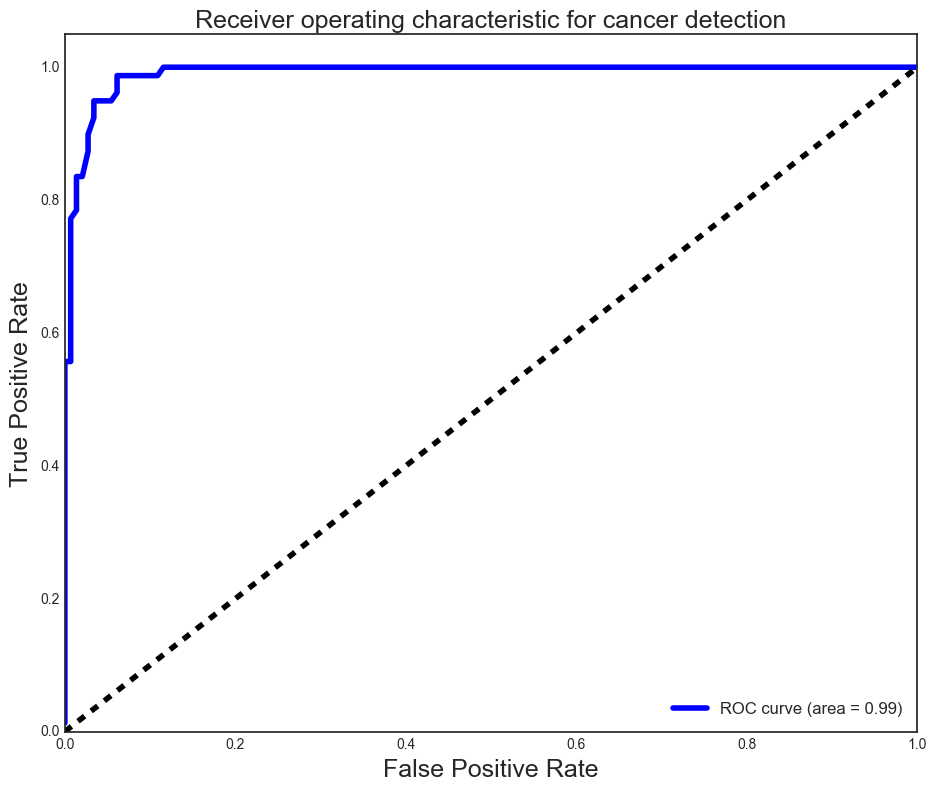

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

What is the intuition for the ROC curve?

As the class assignment threshold decreases for the positive class (has cancer), the false positive rate and true positive rate necessarily increase. For a classifier performing at chance, this would be the diagonal dotted line: an equal chance of false positives and true positives. 

- The greater the area under the curve, the better (in general) the quality of the model

The greater the area under the curve, the higher the ratio of true positives to false positives as the threshold becomes more lenient. Thus, the greater the area under the curve, the higher the quality of the classification model. In the Wisconsin breast cancer data the area under the curve is 0.99, indicating a nearly perfect model. Most classification problems will never get close to this!